$\large\textbf{Notes from 2/10:}\newline$
We decided our original pass for minimizing edges was not usable for a general tree. Instead we decided on a new method of minimizing edges which works as follows: $\newline$

Start at a tree $T_k$ in our tree sequence $T$. For each unary sequence of nodes $\{u_i\}$ in $T_k$ with edge path $P_1\to \cdots\to P_n$ we will check if this path exists in the next tree $T_{k+1}$ (the next tree to the right). If a path exists in $T_{k+1}$ which has same inital and terminal nodes as $T_k$ but does not contain some unary nodes $u_i$ which do not appear elsewhere in $T_{k+1}$ we will extend $P_1\to\cdots\to P_n$ to $T_{k+1}$ by adding the nodes $u_i$. We will not extend the edges from $T_k$ if $u_i$ appears elsewhere in the tree $T_{k+1}$.

We will continue this process across all trees in the sequence. Once we pass to the right most tree, we will run the process across to the left until we reach $T_1$. After this we will once again pass right until tree $T_k$. (We should probably just always start at $T_1$ for simplicities sake). 


# Questions:

1. How can we reduce the number of edges in a tree sequence?
2. Is the equivalent tree sequence with minimal edges unique?
3. How can we be guaranteed to find a tree sequence with minimal edges?

In [1]:
import msprime, tskit
import numpy as np
from IPython.display import display, SVG

In [2]:
ts = msprime.sim_ancestry(3, sequence_length=500, recombination_rate=1e-4, random_seed=6, population_size=100)
ts

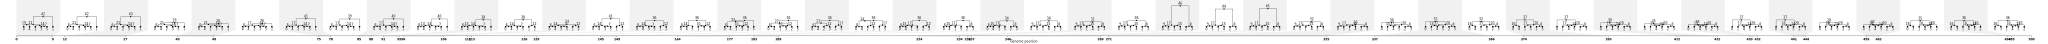

In [3]:
SVG(ts.draw_svg())

In [4]:
t = ts.dump_tables()
print(t.nodes,t.edges)

╔══╤═════╤══════════╤══════════╤═════════════╤════════╗
║id│flags│population│individual│time         │metadata║
╠══╪═════╪══════════╪══════════╪═════════════╪════════╣
║0 │    1│         0│         0│   0.00000000│     b''║
║1 │    1│         0│         0│   0.00000000│     b''║
║2 │    1│         0│         1│   0.00000000│     b''║
║3 │    1│         0│         1│   0.00000000│     b''║
║4 │    1│         0│         2│   0.00000000│     b''║
║5 │    1│         0│         2│   0.00000000│     b''║
║6 │    0│         0│        -1│  13.40994415│     b''║
║7 │    0│         0│        -1│  20.76034502│     b''║
║8 │    0│         0│        -1│  36.98672570│     b''║
║9 │    0│         0│        -1│  48.15007268│     b''║
║10│    0│         0│        -1│  53.82791000│     b''║
║11│    0│         0│        -1│  66.66597183│     b''║
║12│    0│         0│        -1│  77.10681192│     b''║
║13│    0│         0│        -1│  82.36903254│     b''║
║14│    0│         0│        -1│  83.30305919│  

For samples $\{s_i\}$ in our Tree sequence $T$ each sample $s_i$ has a path $P_{i,k}$ for each tree $T_k$ in $T$. Our goal is to compare $P_{i,k}$ and $P_{i,k+1}$. If there are unary nodes in $P_{i,k}$ that are not in $P_{i,k+1}$ we will extend $P_{i,k}$ to $T_{k+1}$.

# TRY EDGE_DIFF ITERATOR #
'''
This function edge_diffs() is an interator over all edges which
are inserted and removed to build trees from left-to-right along
the tree sequence. 
For each e in ts.edge_diffs() we gain a tuple (interval, edges_out, edges_in)
interval: interval on the genome
edges_out: list of edges just removed to create the tree in that interval
edges_in: list of edges just inseted to construct the tree in that interval

'''

An actual attempt at running some algorithm. Our Second Pass

In [8]:
def edge_reduce(ts):
    new_left = t.edges.left
    new_right = t.edges.right
    keep = np.repeat(True, t.edges.num_rows)

    for i1,t1 in enumerate(ts.edge_diffs()): # Cycle through edge_diffs
        for j1,e1 in enumerate(t1[1]): # Cycle through edge_out 
            for j2,e2 in enumerate(t1[1]):
                if j2 != j1:
                    if e1.child == e2.parent: # If we have removed a "chain" of edges cycle through edges_in on next tree in sequence
                        for j3,e3 in enumerate(t1[2]):
                            if e3.parent == e1.parent and e3.child == e2.child: # If e3 is the "edge sum" of e1,e2 then remove e3 and extend e1 and e2.
                                new_right[e1.id] = e3.right
                                new_right[e2.id] = e3.right
                                keep[e3.id] = False

    new_t = t.copy()
    new_t.edges.clear()
    for j, (k,e) in enumerate(zip(keep, ts.edges())):
        if k:
            new_t.edges.add_row(parent = e.parent, child = e.child, left = new_left[j], right = new_right[j])

    new_ts = new_t.tree_sequence()
    return new_ts

In [20]:
new_ts = edge_reduce(ts)
new_t = new_ts.dump_tables() 
print(f"Old number of edges: {t.edges.num_rows}")
print(f"New number of edges: {new_t.edges.num_rows}")

Old number of edges: 129
New number of edges: 118


In [22]:
sts = new_ts.simplify()
ts.tables.assert_equals(sts.tables,ignore_provenance=True) #Still having issues with equality. 

AssertionError: EdgeTable row 89 differs:
self.left=126.0 other.left=177.0
self.right=145.0 other.right=183.0
self.child=5 other.child=8

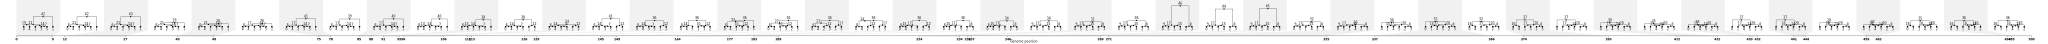

In [18]:
SVG(ts.draw_svg())

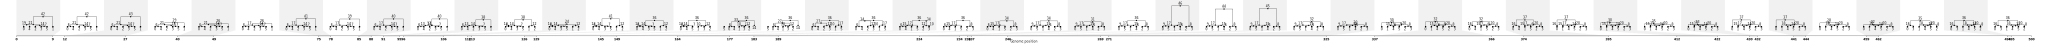

In [19]:
SVG(new_ts.draw_svg())